<h1 style="color:red"> 
1. Load and reading the dataset
</h1>

In [3]:
#For loading data
import pandas as pd

#For analyzing data
import numpy as np

#For visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print('Pandas Version Downloaded: {}'.format(pd.__version__))
print('Numpy Version Downloaded: {}'.format(np.__version__))
print('Seaborn Version Downloaded: {}'.format(sns.__version__))

Pandas Version Downloaded: 1.0.3
Numpy Version Downloaded: 1.18.3
Seaborn Version Downloaded: 0.10.1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#--------------------- Google Colab Code ------------------------------------
#Source: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=tMce8muBqXQP
# Tensorflow with GPU
%tensorflow_version 2.x
import tensorflow as tf
import timeit

# Enabling and testing the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Observe TensorFlow speedup on GPU relative to CPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# knowing the gpu name
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0
Sat May  2 20:13:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |   1697MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [5]:
#--------------------- Jupyter Notebook Code ------------------------------------
#conda install matplotlib=3.1.2
#dataset=pd.read_csv('framingham.csv') #Reading the csv file into a pandas dataframe called "dataset"
#print('\nDataset Size:\n', dataset.shape)


#--------------------- Google Colab Code ------------------------------------
#Mounted the google drive
from google.colab import drive
drive.mount('/content/drive')
#loaded the google drive uploaded dataset into a pandas dataframe
dataset=pd.read_csv('/content/drive/My Drive/framingham.csv') #Reading the csv file into a pandas dataframe called "dataset"
print('\nDataset Size:\n', dataset.shape)
dataset.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset Size:
 (4240, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


<h2 style="color:red"> 
2. Cleaning the dataset (Handling Missing Values, Encoding categorical variables)
</h2>

In [6]:
#Shows the count of NA Values for all the columns of the dataset
#we have missing data for the education, cigsPerDay,BPMeds, totChol, BMI, heartRate and glucose columns
print('Shows the count of NA Values for all the columns of the dataset:\n', dataset.isnull().sum())

Shows the count of NA Values for all the columns of the dataset:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.478e+03, 3.070e+02, 9.660e+02, 6.100e+01, 2.190e+02, 1.030e+02,
        5.900e+01, 6.000e+00, 1.100e+01, 1.000e+00]),
 array([ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63., 70.]),
 <a list of 10 Patch objects>)

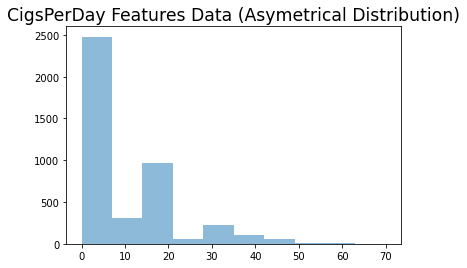

In [7]:
#Graphing data for the cigsPerDay column
plt.title("CigsPerDay Features Data (Asymetrical Distribution)", fontsize="xx-large" )
plt.hist(dataset['cigsPerDay'], alpha=0.5)

In [0]:
#Substituting median for all the NA values in the cigsPerDay column (Numerical data)
# if the data is symmetrical then we use the mean to impute all NA Values
# else if the data is assymetrical then we use the median to impute all NA Values
cigsPerDay_median=dataset['cigsPerDay'].median()
dataset['cigsPerDay'].fillna(cigsPerDay_median,inplace=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.640e+02, 1.555e+03, 1.898e+03, 5.030e+02, 6.000e+01, 7.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([107. , 165.9, 224.8, 283.7, 342.6, 401.5, 460.4, 519.3, 578.2,
        637.1, 696. ]),
 <a list of 10 Patch objects>)

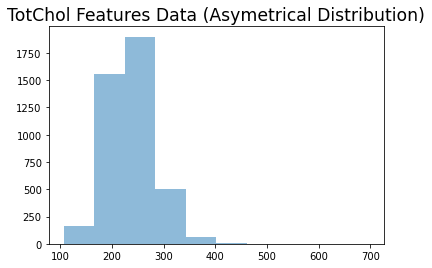

In [9]:
#Graphing data for the totChol column
plt.title("TotChol Features Data (Asymetrical Distribution)", fontsize="xx-large" )
plt.hist(dataset['totChol'], alpha=0.5)

In [0]:
#Substituting median for all the NA values in the totChol column (Numerical data)
# if the data is symmetrical then we use the mean to impute all NA Values
# else if the data is assymetrical then we use the median to impute all NA Values
totChol_median=dataset['totChol'].median()
dataset['totChol'].fillna(totChol_median,inplace=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.580e+02, 1.211e+03, 1.751e+03, 8.240e+02, 1.960e+02, 5.800e+01,
        1.700e+01, 4.000e+00, 1.000e+00, 1.000e+00]),
 array([15.54 , 19.666, 23.792, 27.918, 32.044, 36.17 , 40.296, 44.422,
        48.548, 52.674, 56.8  ]),
 <a list of 10 Patch objects>)

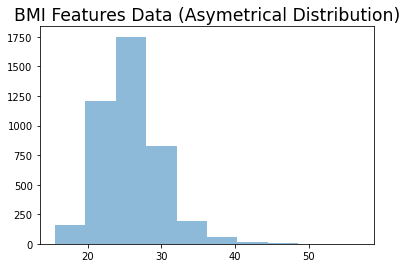

In [11]:
#Graphing data for the BMI column
plt.title("BMI Features Data (Asymetrical Distribution)", fontsize="xx-large" )
plt.hist(dataset['BMI'], alpha=0.5)

In [0]:
#Substituting median for all the NA values in the BMI column (Numerical data)
# if the data is symmetrical then we use the mean to impute all NA Values
# else if the data is assymetrical then we use the median to impute all NA Values
BMI_median=dataset['BMI'].median()
dataset['BMI'].fillna(BMI_median,inplace=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  61.,  538., 1261., 1357.,  646.,  286.,   70.,   14.,    4.,
           2.]),
 array([ 44. ,  53.9,  63.8,  73.7,  83.6,  93.5, 103.4, 113.3, 123.2,
        133.1, 143. ]),
 <a list of 10 Patch objects>)

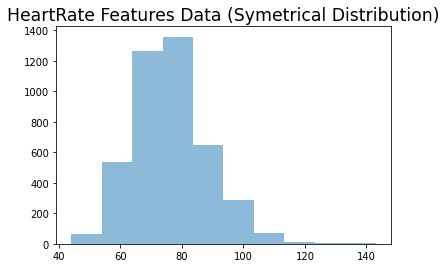

In [13]:
#Graphing data for the heartRate column
plt.title("HeartRate Features Data (Symetrical Distribution)", fontsize="xx-large" )
plt.hist(dataset['heartRate'], alpha=0.5)

In [0]:
#Substituting mean for all the NA values in the HeartRate column (Numerical data)
# if the data is symmetrical then we use the mean to impute all NA Values
# else if the data is assymetrical then we use the median to impute all NA Values
heartRate_mean=dataset['heartRate'].mean()
dataset['heartRate'].fillna(heartRate_mean,inplace=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1573., 2098.,  127.,   16.,   13.,    6.,    7.,    4.,    3.,
           5.]),
 array([ 40. ,  75.4, 110.8, 146.2, 181.6, 217. , 252.4, 287.8, 323.2,
        358.6, 394. ]),
 <a list of 10 Patch objects>)

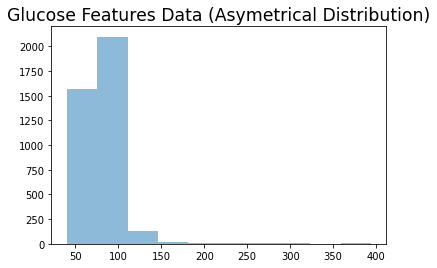

In [15]:
#Graphing data for the glucose column
plt.title("Glucose Features Data (Asymetrical Distribution)", fontsize="xx-large" )
plt.hist(dataset['glucose'], alpha=0.5)

In [0]:
#Substituting mean for all the NA values in the Glucose column (Numerical data)
# if the data is symmetrical then we use the mean to impute all NA Values
# else if the data is assymetrical then we use the median to impute all NA Values
glucose_median=dataset['glucose'].median()
dataset['glucose'].fillna(glucose_median,inplace=True)

In [17]:
#Shows the count of NA Values for all the columns of the dataset
#we no longer have missing data for cigsPerDay totChol, BMI, heartRate and glucose columns
#We still have missing data for education & BPMeds columns only
print('Shows the count of NA Values for all the columns of the dataset:\n', dataset.isnull().sum())

Shows the count of NA Values for all the columns of the dataset:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay           0
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                  0
heartRate            0
glucose              0
TenYearCHD           0
dtype: int64


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1720.,    0.,    0., 1253.,    0.,    0.,  689.,    0.,    0.,
         473.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

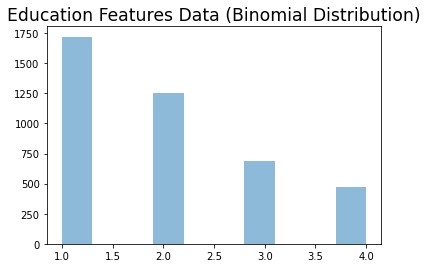

In [18]:
plt.title("Education Features Data (Binomial Distribution)", fontsize="xx-large" )
plt.hist(dataset['education'], alpha=0.5)

In [19]:
print('Finding the frequency of all the values in the education column:\n', dataset['education'].value_counts())

Finding the frequency of all the values in the education column:
 1.0    1720
2.0    1253
3.0     689
4.0     473
Name: education, dtype: int64


In [20]:
education_mode=dataset['education'].value_counts().index[0] # index 0 has highest frequency of occurence which is 1.0
education_mode

1.0

In [0]:
#replace all the NA values with 1.0 in the education column
dataset['education'].fillna(education_mode,inplace=True)

In [22]:
#Shows the count of NA Values for all the columns of the dataset
#we no longer have missing data for the education column
#we still have missing data for the BPMeds column
print('Shows the count of NA Values for all the columns of the dataset:\n', dataset.isnull().sum())

Shows the count of NA Values for all the columns of the dataset:
 male                0
age                 0
education           0
currentSmoker       0
cigsPerDay          0
BPMeds             53
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([4063.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         124.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

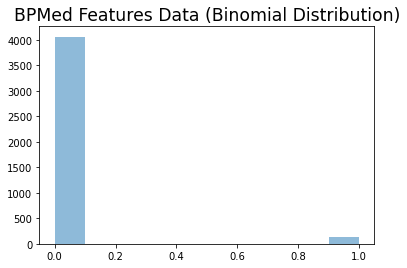

In [23]:
plt.title("BPMed Features Data (Binomial Distribution)", fontsize="xx-large" )
plt.hist(dataset['BPMeds'], alpha=0.5)

In [24]:
print('Finding the frequency of all the values in the BPMeds column:\n', dataset['BPMeds'].value_counts())

Finding the frequency of all the values in the BPMeds column:
 0.0    4063
1.0     124
Name: BPMeds, dtype: int64


In [25]:
BPMeds_mode=dataset['BPMeds'].value_counts().index[0] # index 0 has highest frequency of occurence which is 1.0
BPMeds_mode

0.0

In [0]:
#replace all the NA values with 0.0 in the education column
dataset['BPMeds'].fillna(BPMeds_mode,inplace=True)

In [27]:
#Shows the count of NA Values for all the columns of the dataset
#we no longer have missing data for any of the columns in our dataset
print('Shows the count of NA Values for all the columns of the dataset:\n', dataset.isnull().sum())

Shows the count of NA Values for all the columns of the dataset:
 male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


In [28]:
#Creating the feature matrix from the cleansed dataset
X=dataset.iloc[:,:-1].values #include all the rows of all the columns except for the last column
print("Displaying the feature matrix from the cleansed dataset:\n", X)
print("\nSize of the X Matrix:\n",X.shape)

Displaying the feature matrix from the cleansed dataset:
 [[  1.    39.     4.   ...  26.97  80.    77.  ]
 [  0.    46.     2.   ...  28.73  95.    76.  ]
 [  1.    48.     1.   ...  25.34  75.    70.  ]
 ...
 [  0.    52.     2.   ...  21.47  80.   107.  ]
 [  1.    40.     3.   ...  25.6   67.    72.  ]
 [  0.    39.     3.   ...  20.91  85.    80.  ]]

Size of the X Matrix:
 (4240, 15)


In [29]:
#Creating the target vector from the cleanset dataset
y=dataset.iloc[:,15].values #include all the rows of the last column
print('Displaying the target vector from the cleansed dataset:\n', y)
print("\nSize of the Y Vector:\n",y.shape)

Displaying the target vector from the cleansed dataset:
 [0 0 0 ... 0 0 0]

Size of the Y Vector:
 (4240,)


<h1 style="color:red"> 
3. Encoding Categorical Variable Columns (One Hot Encoding for X Matrix and Label Encoding for Y Vector)
</h1>

#### ------------------------------------------------------What is One Hot Encoding------------------------------------------------------
##### One hot encoding is used for converting columns that contain categorical data into numerical data (1’s and 0’s). One Hot Encoding is useful because a machine learning models only accepts numerical data for doing predictions.            
#### --------------------Rationale for why we didnt do One Hot Encoding or Label Encoding---------------------------
##### X Column's (age, cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate and glucose) are numerical data types; One Hot Encoding was not performed for these X Columns                                                                    
##### X Column's (male, education, currentSmoker, BPMeds, prevalentStroke and diabetes) consists of 1's and 0's; One Hot Encoding was not performed for these X Columns     
##### X Column's (male, education, currentSmoker, BPMeds, prevalentStroke and diabetes) consists of 1's and 0's; One Hot Encoding was not performed for these X Columns                  
##### Y Column (TenYearCHD) consists of 1's and 0's; Label Encoding was not performed on the Y Column

In [30]:
#Splitting the dataset into 80% training dataset and 20% testing dataset from the cleansed dataset
# random state = 0 ensures that the data is not being split randomly everytiem
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

print('\nDataset sizes')
print('\t X_train size:', X_train.shape)
print('\t y_train size:', y_train.shape)
print('\t X_test size:', X_test.shape)
print('\t y_test size:', y_test.shape)


Dataset sizes
	 X_train size: (3392, 15)
	 y_train size: (3392,)
	 X_test size: (848, 15)
	 y_test size: (848,)


<h1 style="color:red"> 
4. Feature Selection (Using Forward Selection to pick columns that have the most impact on the classification models prediction)
</h1>

In [31]:
#importing the libraries in order to implement backward elimination 
#using pythons built in function called SequentialFeatureSelector()
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


--------------------------------------------------------------------------------------
Starting Forward Elimination(Features Kept)  ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14')
--------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


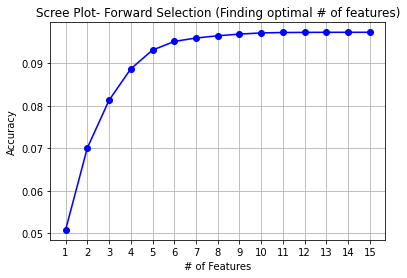

After # of Features =6; increasing the # of features no longer drastically increases the accuracy

--------------------------------------------------------------------------------------
Ending Forward Elimination(Features Kept)  ('0', '1', '4', '6', '10', '14')
--------------------------------------------------------------------------------------


In [32]:
#Data Source used to do forward selections programming: 
# https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f

#Sequential forward selection(using all features)
#if forward = True then Sequential Forward Selection (sfs)
# else if forward = False then Seqeuential Backward Selection (sbs)
sfs = SFS(LinearRegression(), k_features=(1,15), forward=True, floating=False,cv=0)
sfs.fit(X, y)
print("--------------------------------------------------------------------------------------")
print("Starting Forward Elimination(Features Kept) ",sfs.k_feature_names_)
print("--------------------------------------------------------------------------------------")
#plotting the scree plot to determine optimal value for k_features
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Scree Plot- Forward Selection (Finding optimal # of features)')
plt.xlabel('# of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
print("After # of Features =6; increasing the # of features no longer drastically increases the accuracy\n")
print("--------------------------------------------------------------------------------------")
#Recalculating backward selection using the optimal value for k_features
sbs = SFS(LinearRegression(), k_features=(6), forward=True, floating=False,cv=0)
sbs.fit(X, y)
print("Ending Forward Elimination(Features Kept) ",sbs.k_feature_names_)
print("--------------------------------------------------------------------------------------")

In [33]:
X_BE=dataset.iloc[:,[0,1,4,6,10,14]].values #stores all the rows of columns 0,1,4,6,10 & 14 into a new matrix called X_BE
print(X_BE)
print("\nOnly Independant Variables (X1-X6) have impact on predicting Y:")
print("\t Column 0(X1) = male")
print("\t Column 1(x2) = age")
print("\t Column 4(x3) = cigsPerDay")
print("\t Column 6(X4) = prevalentStroke")
print("\t Column 10(x5) = sysBP")
print("\t Column 14(x6) = glucose ")
print("\t Column Y = TenYearCHD")

[[  1.   39.    0.    0.  106.   77. ]
 [  0.   46.    0.    0.  121.   76. ]
 [  1.   48.   20.    0.  127.5  70. ]
 ...
 [  0.   52.    0.    0.  133.5 107. ]
 [  1.   40.    0.    0.  141.   72. ]
 [  0.   39.   30.    0.  133.   80. ]]

Only Independant Variables (X1-X6) have impact on predicting Y:
	 Column 0(X1) = male
	 Column 1(x2) = age
	 Column 4(x3) = cigsPerDay
	 Column 6(X4) = prevalentStroke
	 Column 10(x5) = sysBP
	 Column 14(x6) = glucose 
	 Column Y = TenYearCHD


<h1 style="color:red"> 
5. Splitting the dataset into training and testing datasets
</h1>

In [34]:
#Splitting the dataset into 80% training dataset and 20% testing dataset from the cleansed dataset
# random state = 0 ensures that the data is not being split randomly everytiem
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X_BE,y,test_size=0.2, random_state=0)

print('\nDataset sizes')
print('\t X_train_BE size:', X_train.shape)
print('\t y_train size:', y_train.shape)
print('\t X_test_BE size:', X_test.shape)
print('\t y_test size:', y_test.shape)


Dataset sizes
	 X_train_BE size: (3392, 6)
	 y_train size: (3392,)
	 X_test_BE size: (848, 6)
	 y_test size: (848,)


<h1 style="color:red"> 
6. Normalizing the training and testing datasets
</h1>

In [0]:
#Before we create our classifier, we have to normalize the data (feature scaling) using the
#Scikit-Learn preprocessing package's StandardScalar function .
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train_BE = sc_x.fit_transform(X_train)# fitting & transforming the training dataset
X_test_BE = sc_x.transform(X_test) # transforming the testing dataset

In [36]:
print('\t X_train_BE size:', X_train_BE.shape)
print('\t X_test_BE size:', X_test_BE.shape)

	 X_train_BE size: (3392, 6)
	 X_test_BE size: (848, 6)


<h1 style="color:red"> 
7. Model Studies (After Forward Selection)
</h1>

<h2 style="color:red"> 
7.1 Linear SVM (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.8514150943396226
	Misclassification (Wrong Prediction Rate): 0.1485849056603774


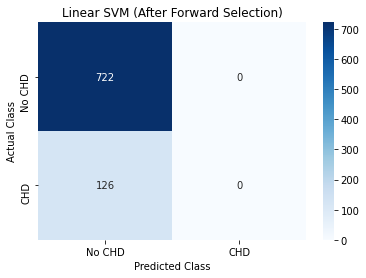

<Figure size 72x72 with 0 Axes>

In [37]:
from sklearn import svm # Importing model library
obj = svm.SVC(kernel='linear', gamma="auto") # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc1=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc1)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc1))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("Linear SVM (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h2 style="color:red"> 
7.2 RBF SVM (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.8514150943396226
	Misclassification (Wrong Prediction Rate): 0.1485849056603774


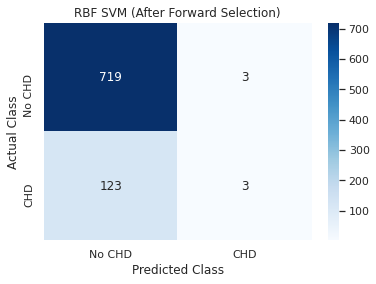

<Figure size 72x72 with 0 Axes>

In [38]:
from sklearn import svm # Importing model library
obj = svm.SVC(kernel='rbf', gamma="auto") # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc2=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc2)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc2))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("RBF SVM (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h2 style="color:red"> 
7.3 Poly SVM (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.8502358490566038
	Misclassification (Wrong Prediction Rate): 0.14976415094339623


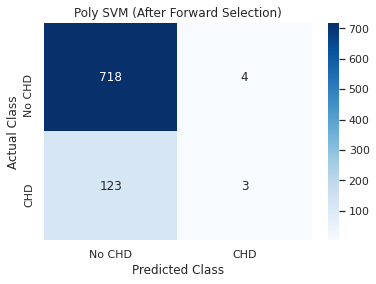

<Figure size 72x72 with 0 Axes>

In [39]:
from sklearn import svm # Importing model library
obj = svm.SVC(kernel='poly', gamma="auto") # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc3=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc3)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc3))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("Poly SVM (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h2 style="color:red"> 
7.4 Logistic Regression (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.8596698113207547
	Misclassification (Wrong Prediction Rate): 0.1403301886792453


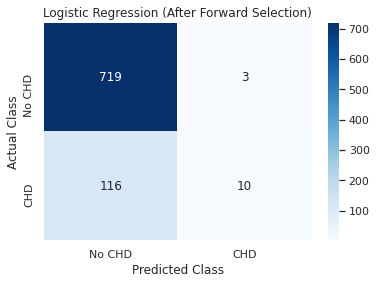

<Figure size 72x72 with 0 Axes>

In [40]:
from sklearn.linear_model import LogisticRegression # Importing model library
obj = LogisticRegression(solver='lbfgs') # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc4=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc4)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc4))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("Logistic Regression (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h2 style="color:red"> 
7.5 Naive Bayes (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.8443396226415094
	Misclassification (Wrong Prediction Rate): 0.1556603773584906


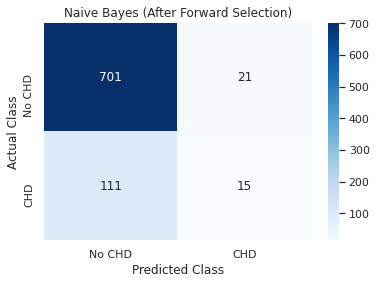

<Figure size 72x72 with 0 Axes>

In [41]:
from sklearn.naive_bayes import GaussianNB # Importing model library
obj = GaussianNB() # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc5=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc5)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc5))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("Naive Bayes (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h2 style="color:red"> 
7.6 Random Forest (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.8431603773584906
	Misclassification (Wrong Prediction Rate): 0.1568396226415094


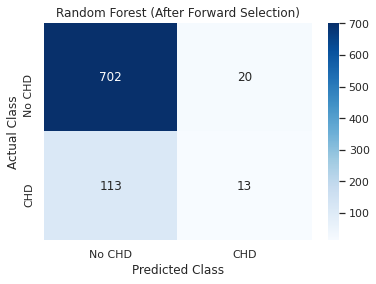

<Figure size 72x72 with 0 Axes>

In [42]:
from sklearn.ensemble import RandomForestClassifier # Importing model library
obj = RandomForestClassifier() # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc6=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc6)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc6))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("Random Forest (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h2 style="color:red"> 
7.7 KNN (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.8384433962264151
	Misclassification (Wrong Prediction Rate): 0.16155660377358494


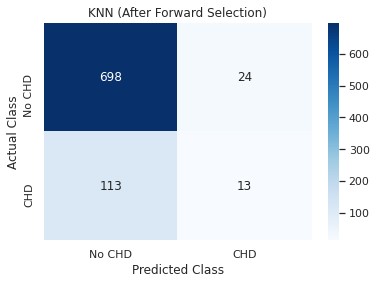

<Figure size 72x72 with 0 Axes>

In [43]:
from sklearn.neighbors import KNeighborsClassifier # Importing model library
obj = KNeighborsClassifier() # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc7=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc7)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc7))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("KNN (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h2 style="color:red"> 
7.8 Decision Tree (After Forward Selection)
</h2>

	Accuracy (Right Prediction Rate): 0.7570754716981132
	Misclassification (Wrong Prediction Rate): 0.24292452830188682


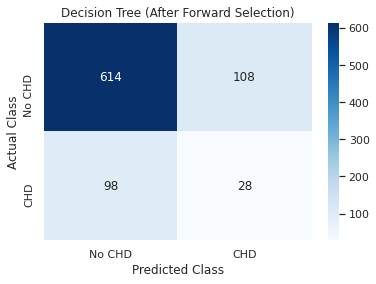

<Figure size 72x72 with 0 Axes>

In [44]:
from sklearn.tree import DecisionTreeClassifier # Importing model library
obj = DecisionTreeClassifier() # creating a model object
obj.fit(X_train_BE, y_train) #Training the model
y_pred=obj.predict(X_test_BE) # making predictions on the training model

#Evaluating the trained models prediction
acc8=obj.score(X_test_BE,y_test)
cm = confusion_matrix(y_test, y_pred)
gPreds=cm[0,0]+cm[1,1]
bPreds=cm[0,1]+cm[1,0]
allPreds=cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
print('\tAccuracy (Right Prediction Rate):',acc8)
print('\tMisclassification (Wrong Prediction Rate):',(1-acc8))

xlabels=['No CHD','CHD']
ylabels=['No CHD','CHD']
df_cm = pd.DataFrame(cm,index=xlabels,columns=ylabels)
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
heatmap_cm=sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
heatmap_cm.set_title("Decision Tree (After Forward Selection)")
plt.figure(figsize = (1,1))
sns.set(font_scale=1)

<h1 style="color:red"> 
7. Model Studies Comparison (After Forward Selection)
</h1>

In [45]:
#create the dataframe
import pandas as pd

data = {
        'Model Name': ['Linear SVM', 'RBF SVM','Poly SVM', 'Logistic Regression', 'Naive Bayes',
                       'Random Forest', 'KNN','Decision Tree'],
    
        'Model Accuracy(After Forward Selection)':[acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8]
       }
df_Accuracy=pd.DataFrame(data)
df_Accuracy

,Model Name,Model Accuracy(After Forward Selection)
0,Linear SVM,0.851415
1,RBF SVM,0.851415
2,Poly SVM,0.850236
3,Logistic Regression,0.859670
4,Naive Bayes,0.844340
5,Random Forest,0.843160
6,KNN,0.838443
7,Decision Tree,0.757075


In [46]:
#sorted dataframe (descending order aka 1st row of the Model Score column shows the max value)
df_SortedAccuracy= df_Accuracy.sort_values(by='Model Accuracy(After Forward Selection)', ascending=False) 
df_SortedAccuracy

,Model Name,Model Accuracy(After Forward Selection)
3,Logistic Regression,0.859670
0,Linear SVM,0.851415
1,RBF SVM,0.851415
2,Poly SVM,0.850236
4,Naive Bayes,0.844340
5,Random Forest,0.843160
6,KNN,0.838443
7,Decision Tree,0.757075


<h1 style="color:red"> 
Conclusion: Forward Selection Results shows that Log Reg gives max accuracy
</h1>